# Import 

In [5]:
# Import torch
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

## Setup device agnostic

In [6]:
# TODO: Setup device agnostic code
from argparse import ArgumentParser

parser = ArgumentParser(description="computer vision model argument")
parser.add_argument("--disable-cuda",  type=bool, default=False, help="Choose cuda device to train model?")
parser.add_argument("--learning-rate", "-lr", type=float, default=.01, help="Learning rate")
parser.add_argument("--epochs", "-e", type=int, default=40, help="Epochs")
parser.add_argument("--MODEL-PATH", type=str, default="../../Module/models", help="Model save path")
parser.add_argument('--file', '-f', type=str)
args = parser.parse_args()

args.device = None
if not args.disable_cuda and torch.cuda.is_available():
    args.device = "cuda"
else:
    args.device = 'cpu'

## Download Dataset

In [7]:
import os
import zipfile
import requests
from pathlib import Path


url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} has already been downloaded...")
else:
    print(f"Folder {image_path} wasn't founded. Creating one...")
    
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(image_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza_steak_sushi.zip...")
        response = requests.get(url)
        f.write(response.content)
        
    with zipfile.ZipFile(image_path / "pizza_steak_sushi.zip") as zip_file:
        print(f"Extracting file...")
        zip_file.extractall(image_path)
        
    print(f"Downloaded Successfully")

data\pizza_steak_sushi has already been downloaded...


## Data Exploding

### Explode shape, Visualize Image

In [8]:
def walk_through_path(folder_path):
    for root, dirs, files in os.walk(folder_path):
        print(f"There are {len(dirs)} directories and {len(files)} files in {root}")
        
walk_through_path(image_path)

There are 2 directories and 1 files in data\pizza_steak_sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\test
There are 0 directories and 25 files in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 files in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 files in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\train
There are 0 directories and 78 files in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 files in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 files in data\pizza_steak_sushi\train\sushi


In [13]:
list(image_path.glob("*/*/*.jpg"))

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

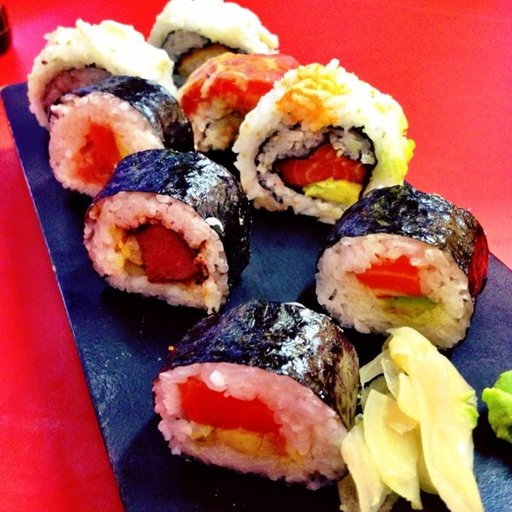

In [19]:
from PIL import Image

Image.open(list(image_path.glob("*/*/*.jpg"))[50])

### Get random image and visualize

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (`PIL` stands for **Python Image Library**).
5. We'll then show the image and print some metadata.

Class name image: sushi
Root directory: data\pizza_steak_sushi\train\sushi\773725.jpg
Width x Height: 382 x 512


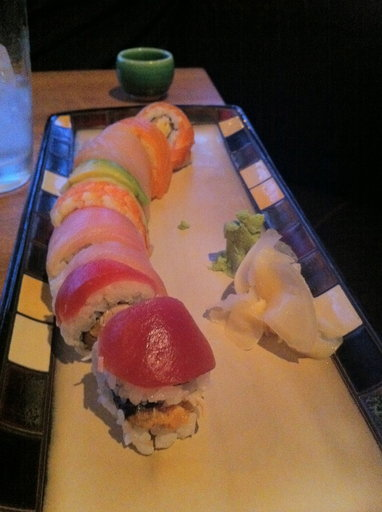

In [29]:
import random
from PIL import Image

random.seed(10)

# Get all image path in every dir and convert it to list
image_list = list(image_path.glob("*/*/*.jpg"))

# Get random image
random_image = random.choice(image_list)

# Get class name
class_random_image = random_image.parent.stem

img = Image.open(random_image)

# Print
print(f"Class name image: {class_random_image}")
print(f"Root directory: {random_image}")
print(f"Width x Height: {img.width} x {img.height}")
img

## 3. Transforming data
Now what if we wanted to load our image data into **PyTorch**?

Before we can use our image data with PyTorch we need to:

- Turn it into tensors (numerical representations of our images).
- Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and *DataLoader* for short.
- There are several different kinds of pre-built datasets and dataset loaders for **PyTorch**, depending on the problem you're working on.

### 3.1 Transforming data with torchvision.transforms
We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

 - Resize the images using `transforms.Resize()` (from about *512x512* to *64x64*, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
 - Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
 - Turn our images from a `PIL` image to a PyTorch tensor using `transforms.ToTensor()`.
 - We can compile all of these steps using `torchvision.transforms.Compose()`.

In [36]:
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import ToTensor

data_transforms = Compose([
    Resize(size=(64, 64)),
    RandomHorizontalFlip(p=.7),
    ToTensor()
])

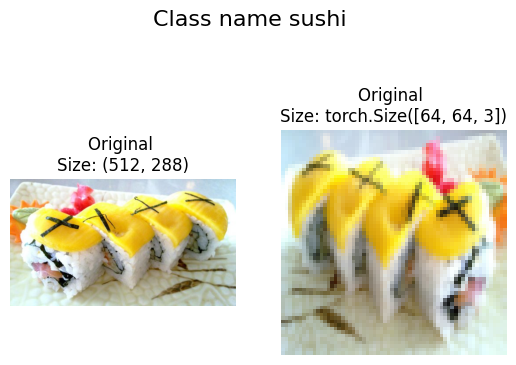

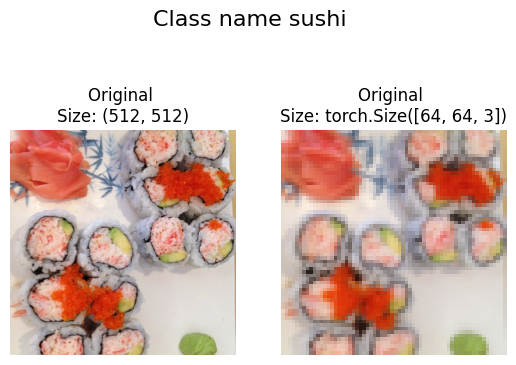

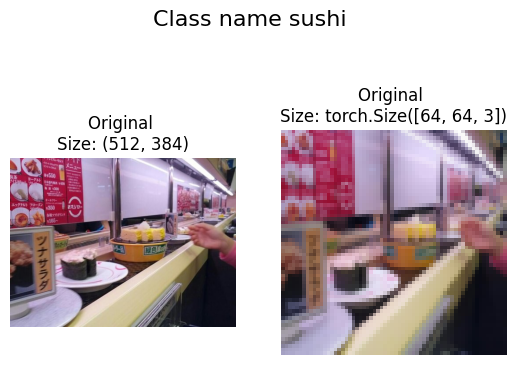

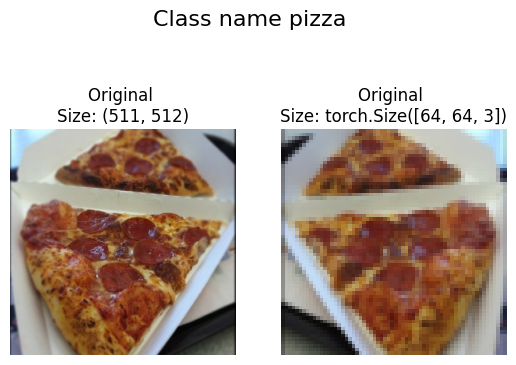

In [40]:
random.seed(82)

def plot_transform_image(image_paths, transforms, n=4):
    """
    Plot transform random n images
    Print class name and size
    
    Arg:
        - image_paths: path to dataset, this must be Path instance
        - transforms: data transform pipeline
        - n: number of image that will be ploted
    """
    image_list = list(image_paths.glob("*/*/*.jpg"))
    image_random_choice = random.sample(list(image_list), k=n)
    for idx, image_path in enumerate(image_random_choice):
        with Image.open(image_path) as img:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(img)
            ax1.set_title(f"Original \nSize: {img.size}")
            ax1.axis(False)
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transforms(img).permute(1, 2, 0)
            ax2.imshow(transformed_image)
            ax2.set_title(f"Original \nSize: {transformed_image.shape}")
            ax2.axis(False)
            
            fig.suptitle(f"Class name {image_path.parent.stem}", fontsize=16)
    
    
plot_transform_image(image_path, data_transforms)
